No trading halts detected.


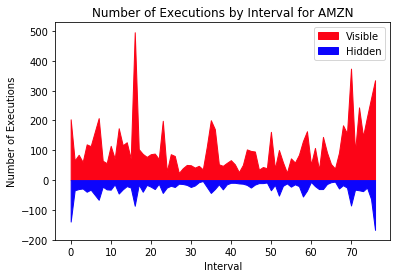

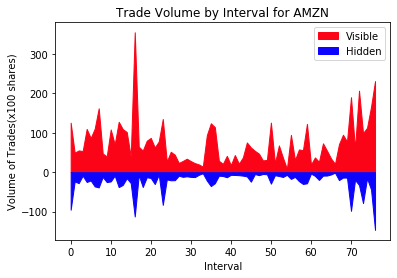

In [4]:
"""
Test LOBSTER data
Convert LOBSTER R code demo into python (https://lobsterdata.com)
  
Dec. 2019 - thertrader@gmail.com
"""
import pandas as pd
from matplotlib import pyplot as plt
import os 
import itertools as it
  
# change the current directory 
os.chdir(r"/home/arno/work/research/lobster") 

# Message file information:
# ----------------------------------------------------------
#
#   - Dimension:    (NumberEvents x 6)
#
#   - Structure:    Each row:
#                   Time stamp (sec after midnight with decimal
#                   precision of at least milliseconds and
#                   up to nanoseconds depending on the period),
#                   Event type, Order ID, Size (# of shares),
#                   Price, Direction
#
#                   Event types:
#                       - '1'   Submission new limit order
#                       - '2'   Cancellation (partial)
#                       - '3'   Deletion (total order)
#                       - '4'   Execution of a visible limit order
#                       - '5'   Execution of a hidden limit order
# 			- '7'   Trading Halt (Detailed 
#                               information below)
#
#                   Direction:
#                       - '-1'  Sell limit order
#                       - '-2'  Buy limit order
#                       - NOTE: Execution of a sell (buy)
#                               limit order corresponds to
#                               a buyer-(seller-) initiated
#                               trade, i.e. a BUY (SELL) trade.
#
# ----------------------------------------------------------
ticker = 'AMZN' 

theMessageBookFileName = "AMZN_2012-06-21_34200000_57600000_message_10.csv"

theMessageBook = pd.read_csv(theMessageBookFileName, names = ['Time','Type','OrderID','Size','Price','TradeDirection'])

startTrad = 9.5*60*60       # 9:30:00.000 in ms after midnight
endTrad = 16*60*60        # 16:00:00.000 in ms after midnight

theMessageBookFiltered = theMessageBook[theMessageBook['Time'] >= startTrad] 
theMessageBookFiltered = theMessageBookFiltered[theMessageBookFiltered['Time'] <= endTrad]


# Note: As the rows of the message and orderbook file correspond to each other, the time index of
# the message file can also be used to 'cut' the orderbook file.

# Check for trading halts Rcode (left untouched for now)
# ----------------------------------------------------------
tradingHaltIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == -1)]

tradeQuoteIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == 0)]

tradeResumeIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == 1)]

if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
    print("No trading halts detected.")
		
if(len(tradingHaltIdx) != 0):
	print("Data contains trading halt! at time stamp(s): "); print(list(tradingHaltIdx))
		
if(len(tradeQuoteIdx) != 0):
	print(" Data contains quoting message! at time stamp(s)"); print(list(tradeQuoteIdx)) 
			
if(len(tradeResumeIdx) != 0):
	print(" Data resumes trading! at time stamp(s) "); print(list(tradeResumeIdx))
		

# ----------------------------------------------------------
#		When trading halts, a message of type '7' is written into the 
#		'message' file. The corresponding price and trade direction 
#		are set to '-1' and all other properties are set to '0'. 
#		Should the resume of quoting be indicated by an additional 
#		message in NASDAQ's Historical TotalView-ITCH files, another 
#		message of type '7' with price '0' is added to the 'message' 
#		file. Again, the trade direction is set to '-1' and all other 
#		fields are set to '0'. 
#		When trading resumes a message of type '7' and 
#		price '1' (Trade direction '-1' and all other 
#		entries '0') is written to the 'message' file. For messages 
#		of type '7', the corresponding order book rows contain a 
#		duplication of the preceding order book state. The reason 
#		for the trading halt is not included in the output.
#						
#		Example: Stylized trading halt messages in 'message' file.				
#	
#		Halt: 			36023	| 7 | 0 | 0 | -1 | -1
#											...
#		Quoting: 		36323 	| 7 | 0 | 0 | 0  | -1
#											...
#		Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
#											...
#		The vertical bars indicate the different columns in the  
#		message file.

# Set Bounds for Intraday Intervals
# ----------------------------------------------------------

# Define interval length
freq = 5 * 60   # Interval length in ms 5 minutes

# Number of intervals from 9:30 to 4:00
noint = int((endTrad-startTrad)/freq)
theMessageBookFiltered.index = range(0,len(theMessageBookFiltered),1)

# Variables for 'for' loop
j = 0
l = 0
bound = []                # Variable for inverval bound
visible_count = []         # visible_count calculates the number of visible trades in an interval of 5 min
hidden_count = []          # hidden_count calculates the number of visible trades in an interval of 5 min
visible_size = []          # Total volume of visible trades in an interval of 5 minutes
hidden_size = []           # Total volume of hidden trades in an interval of 5 minutes

# Set Bounds for Intraday Intervals
bound = []
for j in range(0,noint):
    bound.append(startTrad + j * freq)

#_____________________________________________________________________________
#   
# Plot - Number of Executions and Trade Volume by Interval
#_____________________________________________________________________________
              
# Note: Difference between trades and executions
#
#    The LOBSTER output records limit order executions
#    and not what one might intuitively consider trades.
#
#    Imagine a volume of 1000 is posted at the best ask
#    price. Further, an incoming market buy order of
#    volume 1000 is executed against the quote.
#
#    The LOBSTER output of this trade depends on the
#    composition of the volume at the best ask price.
#    Take the following two scenarios with the best ask
#  	 volume consisting of ...
#    	(a) 1 sell limit order with volume 1000
#    	(b) 5 sell limit orders with volume 200 each
#       	(ordered according to time of submission)
#
#     The LOBSTER output for case ...
#       (a) shows one execution of volume 1000. If the
#           incoming market order is matched with one
#           standing limit order, execution and trade
#           coincide.
#       (b) shows 5 executions of volume 200 each with the
#           same time stamp. The incoming order is matched
#           with 5 standing limit orders and triggers 5
#           executions.
#
#       Bottom line:
#       LOBSTER records the exact limit orders against
#       which incoming market orders are executed. What
#       might be called 'economic' trade size has to be
#       inferred from the executions.


# Logic to calculate number of visible/hidden trades and their volume
for l in range(1,noint):
    visible_count.append(len(theMessageBookFiltered[(theMessageBookFiltered.Time > bound[l-1]) & (theMessageBookFiltered.Time < bound[l]) & (theMessageBookFiltered.Type == 4)])) 
    visible_size.append(sum(theMessageBookFiltered['Size'][(theMessageBookFiltered.Time > bound[l-1]) & (theMessageBookFiltered.Time < bound[l]) & (theMessageBookFiltered.Type == 4)])/100) 
         
    hidden_count.append(len(theMessageBookFiltered[(theMessageBookFiltered.Time > bound[l-1]) & (theMessageBookFiltered.Time < bound[l]) & (theMessageBookFiltered.Type == 5)])) 
    hidden_size.append(sum(theMessageBookFiltered['Size'][(theMessageBookFiltered.Time > bound[l-1]) & (theMessageBookFiltered.Time < bound[l]) & (theMessageBookFiltered.Type == 5)])/100) 


# First plot : Number of Execution by Interval (Visible + Hidden)
plt.title('Number of Executions by Interval for ' + ticker)
plt.fill_between(range(0,len(visible_count)),
                 visible_count,
                 color = '#fc0417',
                 label = 'Visible')
plt.ylabel('Number of Executions')
plt.xlabel('Interval')
plt.legend()

plt.fill_between(range(0,len(visible_count)),
         [x * (-1) for x in hidden_count], 
         color = '#0c04fc',
         label = 'Hidden')
plt.legend()
plt.show()

# Second plot : Trade Volume by Interval (Visible + Hidden)
plt.title('Trade Volume by Interval for ' + ticker)
plt.fill_between(range(0,len(visible_size)),
                 visible_size,
                 color = '#fc0417',
                 label = 'Visible')
plt.ylabel('Volume of Trades(x100 shares)')
plt.xlabel('Interval')
plt.legend()

plt.fill_between(range(0,len(visible_size)),
         [x * (-1) for x in hidden_size], 
         color = '#0c04fc',
         label = 'Hidden')
plt.legend()
plt.show()

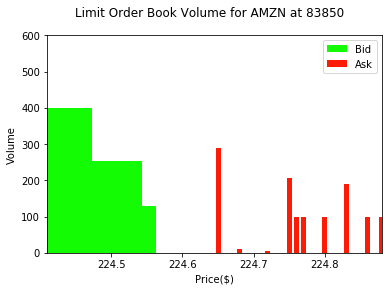

In [5]:
#_____________________________________________________________________________
#
# Load Order Book File
#_____________________________________________________________________________
nlevels = 10

# Load data
theOrderBookFileName = "AMZN_2012-06-21_34200000_57600000_orderbook_10.csv"

col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

theNames = []
for i in range(1, nlevels + 1):
    for j in col:
        theNames.append(str(j) + str(i))

theOrderBook = pd.read_csv(theOrderBookFileName, names = theNames)

# Orderbook file information:
# ----------------------------------------------------------
#
#   - Dimension:    (NumberEvents x (NumberLevels*4))
#
#   - Structure:    Each row:
#                   Ask price 1, Ask volume 1, Bid price 1,
#                   Bid volume 1, Ask price 2, Ask volume 2,
#                   Bid price 2, Bid volume 2, ...
#
#   - Note:         Unoccupied bid (ask) price levels are
#                   set to -9999999999 (9999999999) with volume 0.
#				      
# ----------------------------------------------------------

#_____________________________________________________________________________
#
# Data Preparation - Order Book File
#_____________________________________________________________________________

# Take only order books during the continuous trading period
# from 9:30:00 to 16:00:00
# ----------------------------------------------------------
# Trading hours (start & end)  16:00:00.000 in ms after midnight
timeIndex = theMessageBook.index[(theMessageBook.Time >= startTrad) & (theMessageBook.Time <= endTrad)]

theOrderBookFiltered = theOrderBook[theOrderBook.index == timeIndex]
# Convert prices into dollars
#    Note: LOBSTER stores prices in dollar price times 10000

for i in list(range(0,len(theOrderBookFiltered.columns),2)):
    theOrderBookFiltered[theOrderBookFiltered.columns[i]]  = theOrderBookFiltered[theOrderBookFiltered.columns[i]]/10000 

#_____________________________________________________________________________
#
# Plot - Snapshot of the Limit Order Book
#_____________________________________________________________________________
# Note: Pick a random row/event from the order book
totalrows = len(theOrderBookFiltered)
#random_no = np.random.choice(range(0,totalrows+1), size = None, replace = False, p = None)
random_no = 83850

theAsk = theOrderBookFiltered[theOrderBookFiltered.columns[range(0,len(theOrderBookFiltered.columns),4)]]
theAskVolume = theOrderBookFiltered[theOrderBookFiltered.columns[range(1,len(theOrderBookFiltered.columns),4)]]
 
theAskValues = list(it.chain.from_iterable(theAsk[theAsk.index == random_no].values))
theAskVolumeValues = list(it.chain.from_iterable(theAskVolume[theAskVolume.index == random_no].values))
theDataAsk = pd.DataFrame({'Price': theAskValues, 'Volume': theAskVolumeValues})
theDataAsk = theDataAsk.sort_values(by=['Price'])

theBid = theOrderBookFiltered[theOrderBookFiltered.columns[range(2,len(theOrderBookFiltered.columns),4)]]
theBidVolume = theOrderBookFiltered[theOrderBookFiltered.columns[range(3,len(theOrderBookFiltered.columns),4)]]
 
theBidValues = list(it.chain.from_iterable(theBid[theBid.index == random_no].values))
theBidVolumeValues = list(it.chain.from_iterable(theBidVolume[theBidVolume.index == random_no].values))
theDataBid = pd.DataFrame({'Price': theBidValues, 'Volume': theBidVolumeValues})
theDataBid = theDataBid.sort_values(by=['Price'])

# Chart
fig = plt.figure()
ax = fig.add_subplot(111)

plt.ylim(0,max(theDataBid['Volume'].max(),theDataAsk['Volume'].max()) + 200)
plt.xlim(min(theDataBid['Price'].min(),theDataAsk['Price'].min()), max(theDataBid['Price'].max(),theDataAsk['Price'].max()))
plt.suptitle('Limit Order Book Volume for ' + ticker + ' at ' + str(random_no))
plt.ylabel('Volume')
plt.xlabel('Price($)')

ax.bar(theDataBid['Price'], theDataBid['Volume'], width = 0.007, color='#13fc04', label='Bid')
ax.bar(theDataAsk['Price'], theDataAsk['Volume'], width = 0.007, color='#fc1b04', label='Ask')
       
plt.legend()       
plt.show()


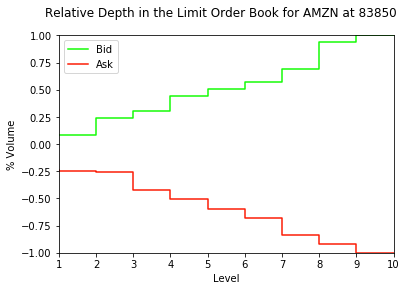

In [6]:
#_____________________________________________________________________________
#
# Plot - Relative Depth in the Limit Order Book
#_____________________________________________________________________________
# Plot variables
theAskVolume = theOrderBookFiltered[theOrderBookFiltered.columns[range(1,len(theOrderBookFiltered.columns),4)]]
totalSizeAsk = list(theAskVolume[theAskVolume.index == random_no].values.cumsum())
percentAsk = totalSizeAsk/totalSizeAsk[len(totalSizeAsk)-1]

theBidVolume = theOrderBookFiltered[theOrderBookFiltered.columns[range(3,len(theOrderBookFiltered.columns),4)]]
totalSizeBid = list(theBidVolume[theBidVolume.index == random_no].values.cumsum())
percentBid = totalSizeBid/totalSizeBid[len(totalSizeBid)-1]

# Chart
fig = plt.figure()
ax = fig.add_subplot(111)

plt.ylim(-1,1)
plt.xlim(1,10)
plt.suptitle('Relative Depth in the Limit Order Book for ' + ticker + ' at ' + str(random_no))
plt.ylabel('% Volume')
plt.xlabel('Level')

ax.step(list(range(1,11)), percentBid, color='#13fc04', label='Bid')
ax.step(list(range(1,11)), -percentAsk, color='#fc1b04', label='Ask')

plt.legend()       
plt.show()


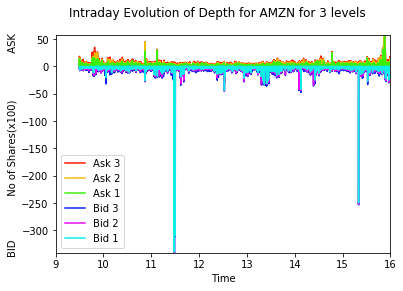

In [7]:
#_____________________________________________________________________________
#
# Plot - Intraday Evolution of Depth
#_____________________________________________________________________________
# Calculate the max/ min volume to set limit of y-axis
maxAskVol = max(theOrderBookFiltered['Ask Size 1'].max()/100,theOrderBookFiltered['Ask Size 2'].max()/100,theOrderBookFiltered['Ask Size 3'].max()/100)  # calculate the maximum ask volume

# Calculate the max Bid volume , we use negative here and calculate min as we plot Bid below X-axis
maxBidVol = min(-theOrderBookFiltered['Bid Size 1'].max()/100,-theOrderBookFiltered['Bid Size 2'].max()/100,-theOrderBookFiltered['Bid Size 3'].max()/100)  # calculate the maximum ask volume

aa = range(int(theMessageBookFiltered['Time'].min()/(60*60)), int(theMessageBookFiltered['Time'].max()/(60*60))+2)
theTime = [int(i) for i in aa] 

fig = plt.figure()
ax = fig.add_subplot(111)

plt.ylim(maxBidVol,maxAskVol)
plt.xlim(theTime[0],theTime[len(theTime)-1])
plt.suptitle('Intraday Evolution of Depth for ' + ticker + ' for 3 levels')
plt.ylabel('BID              No of Shares(x100)               ASK')
plt.xlabel('Time')
#plt.grid(True)

askSizeDepth3 = (theOrderBookFiltered['Ask Size 1']/100) + (theOrderBookFiltered['Ask Size 2']/100) + (theOrderBookFiltered['Ask Size 3']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        askSizeDepth3, 
        color='#fc1b04', 
        label='Ask 3')

askSizeDepth2 = (theOrderBookFiltered['Ask Size 1']/100) + (theOrderBookFiltered['Ask Size 2']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        askSizeDepth2, 
        color='#eeba0c', 
        label='Ask 2')

askSizeDepth1 = (theOrderBookFiltered['Ask Size 1']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        askSizeDepth1, 
        color='#3cee0c', 
        label='Ask 1')

bidSizeDepth3 = (theOrderBookFiltered['Bid Size 1']/100) + (theOrderBookFiltered['Bid Size 2']/100) + (theOrderBookFiltered['Bid Size 3']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        -bidSizeDepth3, 
        color='#0c24ee', 
        label='Bid 3')

bidSizeDepth2 = (theOrderBookFiltered['Bid Size 1']/100) + (theOrderBookFiltered['Bid Size 2']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        -bidSizeDepth2, 
        color='#e40cee', 
        label='Bid 2')

bidSizeDepth1 = (theOrderBookFiltered['Bid Size 1']/100)
ax.plot((theMessageBookFiltered['Time']/(60*60)), 
        -bidSizeDepth1, 
        color='#0ceee7', 
        label='Bid 1')

plt.legend(loc='lower left')       
plt.show()
